In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Context
This is the solution for the [Synthanic competition](https://www.kaggle.com/c/tabular-playground-series-apr-2021) on Kaggle.

The goal is to perform EDA and create a model solving binary classification task using [synthetic dataset](https://www.kaggle.com/c/tabular-playground-series-apr-2021/data) which is based on a real Titanic dataset. The statistical properties of this dataset are similar to the original Titanic dataset.

#### Data Dictionary
The DataFrame contains 100 000 entries with 11 parameters.

Variables description
- Survived: 1 - survived, 0 - died
- Pclass: ticket class
- SibSp: number of siblings/spouses aboard the Titanic
- Parch: number of parents/children aboard the Titanic
- Ticket: ticket number
- Fare: passenger fare
- Cabin: cabin number
- Embarked: port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
data = pd.read_csv('train.csv', index_col='PassengerId')
data.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
67493,1,1,"Larsen, Mona",female,30.0,1,0,72914,78.86,D14301,C
38645,0,3,"Hudnell, Carlos",male,40.0,0,2,43930,15.81,NaN,S
97961,0,2,"Amos, Ronald",male,39.0,0,0,14250,21.77,NaN,S
39854,0,2,"Quiroga, William",male,41.0,0,0,476526,45.17,NaN,S
20380,0,2,"Hurt, Matthew",male,30.0,0,0,STON/O 3658083,9.52,NaN,S
7512,0,3,"Flint, Sheri",female,47.0,0,0,430747,5.81,NaN,C
14927,0,3,"Glenn, Jeffrey",male,61.0,0,0,SOTON/O.Q.,9.60,NaN,S
40159,1,2,"Ishak, Wilbur",male,56.0,0,0,314745,7.60,NaN,S
92374,1,1,"Fletcher, Anna",female,60.0,2,2,332591,73.30,B13266,C


# Data quality assessment


The usefulness of data and its quality are closely related. The rule "garbage in => garbage out" always works. Let's examine quality of our dataset.

First, let's discover whether our DataFrame has missed values.

In [3]:
print(f'Raws {data.shape[0]}')
print(f'Columns {data.shape[1]}')

Raws 100000
Columns 11


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


There are following groups of columns:

1. **categorical:** Name, Ticket, Cabin, Pclass, Survived, Sex, Embarked
2. **numeric:** PassengerId, Age, Fare, SibSp, Parch

In [5]:
data.duplicated().sum()

0

Duplicates not found.

### Handling missing values

In [6]:
data.isna().sum() / data.shape[0]

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

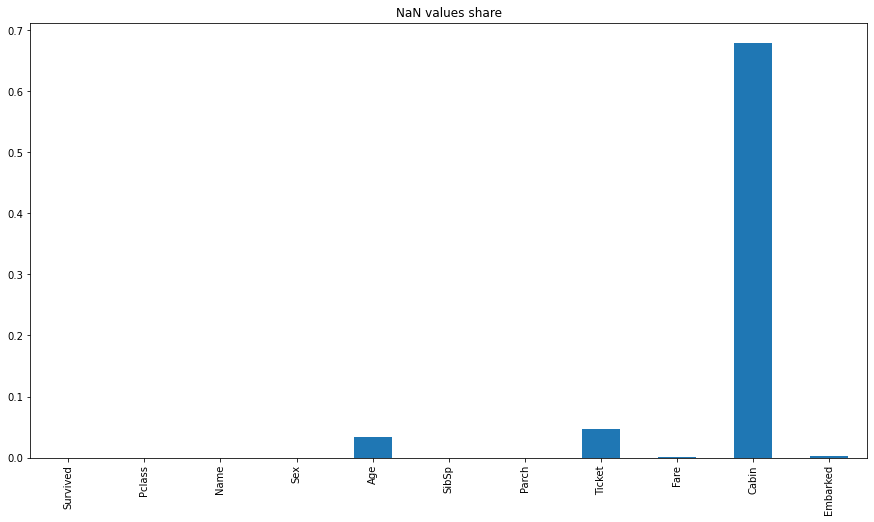

In [7]:
plt.figure(figsize=(15,8))
plt.title("NaN values share")
(data.isna().sum() / data.shape[0]).plot(kind='bar', stacked=True)
plt.show()

Most of Cabin values are lost. Let's introduce new category *'Unknown'* for missing values in the Cabin column. We will do the same for the Ticket column.

In [8]:
data['Ticket'].fillna('Unknown', inplace=True)
data['Cabin'].fillna('Unknown', inplace=True)

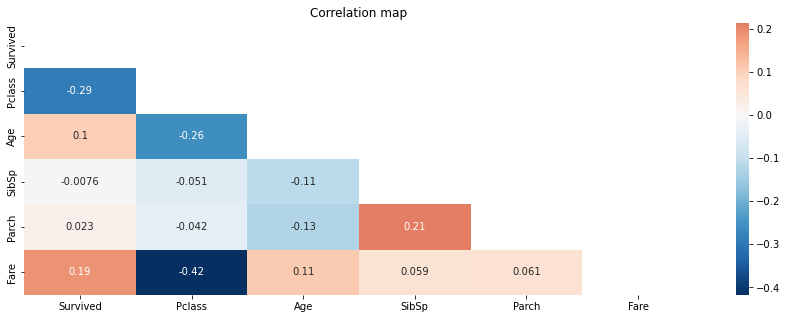

In [9]:
plt.figure(figsize=(15, 5))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(), cmap="RdBu_r", annot=True, center=0, mask=mask)
plt.title('Correlation map')
plt.show()

From the graph above we can see, that Pclass and Fare have negative correlation, thus the higher ticket class number the lower its fare. Let's fill NaN values for each ticket class with it's meadian value. 

In [10]:
medians = data.groupby('Pclass')['Fare'].median()
data['Fare'].fillna(data['Pclass'].map(medians), inplace=True)

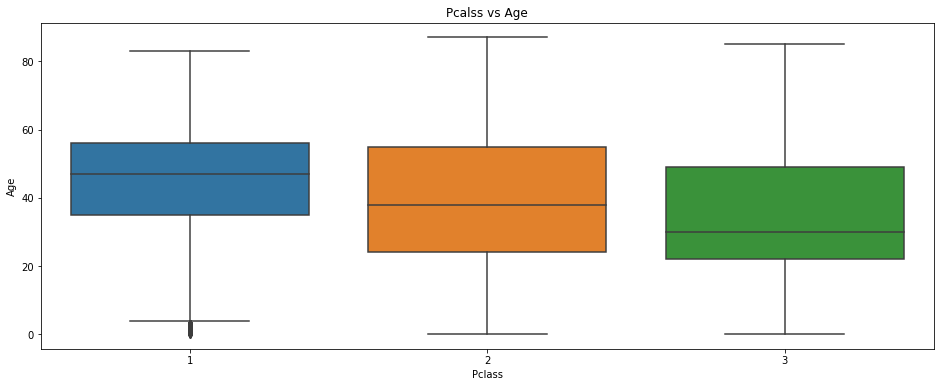

In [11]:
plt.figure(figsize=(16,6))
sns.boxplot(x=data.Pclass, y=data.Age)
plt.title('Pcalss vs Age')
plt.show()

Also we can notice that people with higher ticket class are tended to be older, this may mean that older people can afford more expensive tickets. Let's replace Age column NaNs with medians of each class.

In [12]:
medians = data.groupby('Pclass')['Age'].median()
data['Age'].fillna(data['Pclass'].map(medians), inplace=True)

In [ ]:
tidy = df.drop(['Cabin', 'Ticket', 'Name'], axis=1)
tidy.isna().sum()

Embarked column contains 250 NaN values, let's replace them with mode.

In [ ]:
tidy.Embarked = tidy.Embarked.fillna(tidy.Embarked.mode()[0])
tidy.isna().sum()

In [ ]:
zz

Now, when we finished with missing data, let's do some sanity checks of our features.

Let's assume that children under 10 years cannot have a transatlantic journey without siblings or parents. We replace their age, just as we did with NaN values, with the median of each ticket class.

In [ ]:
tidy.loc[tidy[(tidy.Age < 10) & (tidy.Parch == 0) & (tidy.SibSp == 0)].index, 'Age'] = np.nan
tidy['Age'] = tidy['Age'].fillna(tidy['Pclass'].map(medians))

Boxplot below of initial distribution of fares for every ticket class shows a large number of outliers. We can remove by implementing the IQR method.

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x=tidy.Pclass, y=tidy.Fare)
plt.show()

In [ ]:
first_class, second_class, third_class = tidy[tidy.Pclass == 1], tidy[tidy.Pclass == 2], tidy[tidy.Pclass == 3]
Q1, Q3 = first_class.Fare.quantile(0.25), first_class.Fare.quantile(0.75)
IQR = Q3 - Q1
tidy = tidy.drop(first_class.Fare[((first_class.Fare < (Q1-1.5*IQR)) | (first_class.Fare>(Q3+1.5*IQR)))].index)

Q1, Q3 = second_class.Fare.quantile(0.25), second_class.Fare.quantile(0.75)
IQR = Q3 - Q1
tidy = tidy.drop(second_class.Fare[((second_class.Fare < (Q1-1.5*IQR)) | (second_class.Fare>(Q3+1.5*IQR)))].index)

Q1, Q3 = third_class.Fare.quantile(0.25), third_class.Fare.quantile(0.75)
IQR = Q3 - Q1
tidy = tidy.drop(third_class.Fare[((third_class.Fare < (Q1-1.5*IQR)) | (third_class.Fare>(Q3+1.5*IQR)))].index)

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x=tidy.Pclass, y=tidy.Fare)
plt.show()

After we got rid of the outliers, we can start the analysis.

# Data exploration

First, let's plot some graphs to get a general idea of the distribution of the data.

In [ ]:
tidy.head()

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(tidy.Survived.value_counts(), autopct = '%.2f%%')
plt.title('Survived people distribution')
plt.legend(title="Survived", labels=['No', 'Yes'])
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(tidy.Pclass.value_counts().sort_index(), autopct = '%.2f%%')
plt.title('Ticket class distribution')
plt.legend(title="Ticket class", labels=['1', '2', '3'])
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(tidy.Sex.value_counts().sort_index(), autopct = '%.2f%%')
plt.title('Sex distribution')
plt.legend(title="Sex", labels=['Female', 'Male'])
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(tidy.Age, kde=False, bins=20, norm_hist=True)
plt.title('Age distribution')
plt.show()

Let's add one feature that will store the total number of all relatives on board and plot its destribution. For entries with more than 5 relatives, we assign its value just to 10

In [ ]:
tidy['Relatives'] = tidy['SibSp'] + tidy['Parch']
tidy.loc[tidy[tidy.Relatives >= 5].index, 'Relatives'] = 5
plt.figure(figsize=(16,5))
sns.barplot(x=tidy.Relatives.value_counts().index, y=tidy.Relatives.value_counts().values, palette="Accent")
plt.title('Relatives onboard distribution')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(tidy.Fare, kde=False, bins=30, norm_hist=True)
plt.title('Fare distribution')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x=tidy.Embarked.value_counts().index, y=tidy.Embarked.value_counts().values, palette="Accent")
plt.title('Port of embarkation distribution')
plt.show()

First findings:
- Most people died
- Most people had 3rd (the cheapest) ticket class
- About 57% of passengers were male
- Most people traveled alone
- More people embarked in Southampton

Now let's have a look at how all this attributes affect chance of passengers survived.

In [ ]:
tidy_plot = tidy.groupby(['Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)
tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Age vs Survival')
plt.show()

There's quite strong correlation between ticket class and survivability. **People with tickets of 1st and 2nd class more likely to survive** 

In [ ]:
tidy_plot = tidy.groupby(['Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)
tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Sex vs Survival')
plt.show()

**Women in general have a very high chance of survival compared to men.**

In [ ]:
bins=[0,21,41,61,81,100]
labels = ['0-20','21-40','41-60','61-80','81-100']
tidy['AgeGroup'] = pd.cut(tidy.Age, bins=bins, labels=labels, right=False)

tidy_plot = tidy.groupby(['Survived', 'AgeGroup']).size().reset_index().pivot(columns='Survived', index='AgeGroup', values=0)
tidy_plot.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Age vs survival')
plt.show()

We grouped ages into a few bins. As plot shows, **there is no strong correlation between age and chance to survive in general** except for 61-80 group, but we can explain this by the fact that older people tend to travel with tickets of higher class.

Let's look how ticket class, gender and age of its owner affect chances to survive.

In [ ]:
sns.catplot(x='AgeGroup', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

**Older female and male people in 1st class are more likely to survive**. Male people in 3rd class have the lowest chance to survive**

Now let's look if number of relatives on board affect changes to survive.

In [ ]:
tidy_plot = tidy.groupby(['Survived', 'Relatives']).size().reset_index().pivot(columns=['Survived'], index='Relatives', values=0)
tidy_plot.plot(kind='bar', figsize=(15,6))
plt.title('Number of relatives vs Survival')
plt.show()

The plot above shows that people without any relatives and big families are less likely to survive. Let's add Sex of a person to the plot.

In [ ]:
sns.catplot(x='Relatives', col='Sex', hue='Survived', data=tidy, kind='count')

The absence or small number of relatives provides a higher chance of survival for women. Now find out if ticket class has affect.

In [ ]:
sns.catplot(x='Relatives', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

**Women in 3rd class with high number of relatives are less likely to survive.**

In [ ]:
sns.catplot(x='Embarked', col='Sex', row='Pclass', hue='Survived', data=tidy, kind='count')

People who embarked in Cherbourg and Queenstown are more likely to survive.

In [ ]:
sns.catplot(x='Sex', col='Pclass', hue='Survived', data=tidy, kind='count')

# Summary

We processed the data: filled in the gaps, did some "sanity checks", got rid off outliers in Fare column, and added the AgeGroup and Relatives attributes, which simplified the analysis.

We identified a few patterns in the data:
- People with tickets of 1st and 2nd class more likely to survive, male in 3rd class have the least chance to survive
- Women in general have a very high chance of survival compared to men
- There is no strong correlation between age and chance to survive in general, but older people in 1st class are more likely to survive
- The absence or small number of relatives provides a higher chance of survival for women
- Women in 3rd class with high number of relatives are less likely to survive
- People who embarked in Cherbourg and Queenstown throughout all ticket classes and genders are more likely to survive.